# Проект "Исследование данных стримингового сервиса "Netflix"

В распоряжении имеются данные из открытого источника(Kaggle.com) о фильмах и телешоу, доступных на стримминговом сервисе "Netflix".

**Задача:** Провести разведовательный анализ данных, выявить закономерности.

**Структура данных**:
* ***show_id*** - id фильма или телешоу,
* ***type***  - тип(фильм или телешоу),
* ***title***  - название,
* ***director***  - режиссер,
* ***cast***  - актерский состав,
* ***country***  - страна производства,
* ***date_added***  - дата добавления фильма или телешоу в Netflix,
* ***release_year***  - год релиза фильма или телешоу,
* ***rating***  - рейтинг,
* ***duration***  - продолжительность,
* ***listed_in***  - жанры,
* ***description***  - краткое описание

**Используемые инструменты:**  
Python:
1. pandas (работа с пропусками, типами данных,  группировка, cdjlyst nf,kbws),
2. seaborn, matplotlib (визуалиция данных)),
3. math - вычисление факториала,
4. collections - вычисление количества уникальных значений

**Результат:** 
Проведена предобработка данных, изучено количество контента в зависимости от возрастного рейтинга,  определены средняя  и медианная продолжительность фильмов и телешоу, изучено количество контента в зависимости от года релиза и даты размещения на сервисе, объявлена функция анализа количества уникальных значений в столбцах с множественными значениями, проведен статистический анализ средней длительности фильмов,  относящихся к разным возрастным рейтингам.

## Загрузка и ознакомление с данными

### Импорт необходимых библиотек

In [1]:
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns

from scipy import stats as st
from math import factorial

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

### Загрузка и ознакомление с данными. 

In [2]:
data = pd.read_csv("...")

In [3]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


Столбец с кратким описанием не представляет интереса для целей исследования, поэтому его целесообразнее удалить.

In [4]:
data.drop('description', axis = 1, inplace = True)

Объявим функцию вывода основной информации о столбцах датафрейма.

In [5]:
def inform (data, dict_1 = None):
    '''Данная функция принимает в качестве аргумента датафрейм и выводит основную информацию о каждом из его столбцов:
    * наименование столбца, его описание на русском языке(в случае, если вторым аргументом в функцию передан 
    словарь содержащий необходимую информацию);
    * тип данных;
    * информацию о наличии пропусков и выбросов.
    '''
    if dict_1 == None:
        dict_1 = {}
    print(f'Количество строк в датафрейме: {data.shape[0]}\n\nИнформация о столбцах датафрейма:\n')
    n = 1
    for column in data.columns:
        print(n,')',sep = '', end = ' ')
        try:
            print(f'Столбец "{column}" - {dict_1[column]}:')
        except:
            print(f'Столбец "{column}":')
        print(f'Тип данных: {data[column].dtype}')
        print(f'Количество уникальных значений: {data[column].nunique()}.')
        if data[column].isna().sum() == 0:
            print('Пропуски отсутствуют.')
        else: 
            print(f'Количество пропусков в столбце: {data[column].isna().sum()} ({data[column].isna().sum()/len(data):.2%}).')
        try:
            q1,q3 = data[column].quantile(0.25), data[column].quantile(0.75)
            iqr = q3 - q1
            data1 = data.loc[(data[column] < (q3 + 1.5*iqr)) & (data[column] > (q1 - 1.5*iqr))]
            length = len(data1)+data[column].isna().sum()
            if length == len(data):
                print('Выбросы отсутствуют.')
            else:
                print(f'Количество выбросов в столбце: {len(data) - length} ({(len(data) - length)/len(data):.2%}).')
        except:
            pass
        print('-'*45)
        n+=1

Подготовим словарь, содержащий описание столбцов на русском языке.

In [6]:
columns_name = {'show_id': 'id фильма или телешоу',
                'type': 'тип контента(фильм или телешоу)',
                'title': 'название',
                'director': 'режиссер',
                'cast': 'актерский состав',
                'country': 'страна производства',
                'date_added': ' дата добавления фильма или телешоу в Netflix',
                'release_year': 'год релиза',
                'rating': 'рейтинг',
                'duration': 'продолжительность',
                'listed_in': 'жанры',
                'description': ' краткое описание'}

Выведем основную информацию о каждом из столбцов датафрейма.

In [7]:
inform(data, columns_name)

Количество строк в датафрейме: 8807

Информация о столбцах датафрейма:

1) Столбец "show_id" - id фильма или телешоу:
Тип данных: object
Количество уникальных значений: 8807.
Пропуски отсутствуют.
---------------------------------------------
2) Столбец "type" - тип контента(фильм или телешоу):
Тип данных: object
Количество уникальных значений: 2.
Пропуски отсутствуют.
---------------------------------------------
3) Столбец "title" - название:
Тип данных: object
Количество уникальных значений: 8807.
Пропуски отсутствуют.
---------------------------------------------
4) Столбец "director" - режиссер:
Тип данных: object
Количество уникальных значений: 4528.
Количество пропусков в столбце: 2634 (29.91%).
---------------------------------------------
5) Столбец "cast" - актерский состав:
Тип данных: object
Количество уникальных значений: 7692.
Количество пропусков в столбце: 825 (9.37%).
---------------------------------------------
6) Столбец "country" - страна производства:
Тип данных: 

В данных представлена информация о 8807 фильмах(сериалах), размещенных на стримминговом сервисе.

На этапе предобработки необходимо:
1. Изменить тип данных в столбце с датой добавления фильма или телешоу в Netflix,
2. Проработать пропуски,
3. Обработать значения в столбце с продолжительностью фильма(телешоу), с целью приведения значений в численный формат для дальнейшего анализа.

Проверку на наличие дубликатов проводить нецелесообразно, так как количество уникальных значений в столбце с названиями фильмов (также как и в столбце с ID) совпадает с числом строк в датафрейме.

## Предобработка данных 

### Корректировка типов данных

Значения в столбце 'date_added' приводим в формат даты.

In [8]:
data['date_added'] = pd.to_datetime(data['date_added'].str.strip(), format = '%B %d, %Y')

### Работа с пропусками

В столбцах 'rating','duration' и 'date_added' пропусков гораздо менее 1%, поэтому строки с пропущенными значениями можно удалить.  

Пропуски в столбцах 'director', 'cast', 'country' и 'listed_in'заменяем на значение 'unknown'("не известно", "не определено").

In [9]:
data.dropna(subset=['rating','duration','date_added'], inplace = True)

for i in ['director', 'cast', 'country', 'listed_in']:
    data[i].fillna('unknown',inplace = True)

Утояняем корректность внесенных изменений.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8790 entries, 0 to 8806
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8790 non-null   object        
 1   type          8790 non-null   object        
 2   title         8790 non-null   object        
 3   director      8790 non-null   object        
 4   cast          8790 non-null   object        
 5   country       8790 non-null   object        
 6   date_added    8790 non-null   datetime64[ns]
 7   release_year  8790 non-null   int64         
 8   rating        8790 non-null   object        
 9   duration      8790 non-null   object        
 10  listed_in     8790 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 824.1+ KB


По итогам предобработки из фрейма удалено 17 строк. Тип данных откорректирован.

### Приведение значений в столбце с продолжительностью в целочисленный формат.

Продолжительсть в данных указана в двух форматах:
* продолжительность в минутах,
* продолжительность в сезонах.
    
Беглое ознакомление с данными позволяет предположить, что в минутах указана продолжительность фильмов, в сезонах - продолжительность телешоу. Для подтверждения данного предположения изучим уникальные значения в столбце, в группировке по типу контента.

In [11]:
data.loc[data['type'] == 'Movie', 'duration'].unique()

array(['90 min', '91 min', '125 min', '104 min', '127 min', '67 min',
       '94 min', '161 min', '61 min', '166 min', '147 min', '103 min',
       '97 min', '106 min', '111 min', '110 min', '105 min', '96 min',
       '124 min', '116 min', '98 min', '23 min', '115 min', '122 min',
       '99 min', '88 min', '100 min', '102 min', '93 min', '95 min',
       '85 min', '83 min', '113 min', '13 min', '182 min', '48 min',
       '145 min', '87 min', '92 min', '80 min', '117 min', '128 min',
       '119 min', '143 min', '114 min', '118 min', '108 min', '63 min',
       '121 min', '142 min', '154 min', '120 min', '82 min', '109 min',
       '101 min', '86 min', '229 min', '76 min', '89 min', '156 min',
       '112 min', '107 min', '129 min', '135 min', '136 min', '165 min',
       '150 min', '133 min', '70 min', '84 min', '140 min', '78 min',
       '64 min', '59 min', '139 min', '69 min', '148 min', '189 min',
       '141 min', '130 min', '138 min', '81 min', '132 min', '123 min',
       '65

In [12]:
data.loc[data['type'] != 'Movie', 'duration'].unique()

array(['2 Seasons', '1 Season', '9 Seasons', '4 Seasons', '5 Seasons',
       '3 Seasons', '6 Seasons', '7 Seasons', '10 Seasons', '8 Seasons',
       '17 Seasons', '13 Seasons', '15 Seasons', '12 Seasons',
       '11 Seasons'], dtype=object)

Продолжительность фильмов указана только в минутах, телешоу - только в сезонах.

Объявим функцию, необходимую для преобразования значений столбца в целочисленный формат.

In [13]:
def numeric_duration(cell):
    '''Функция принимает на вход ячейку и извлекает из нее численное значение.
    '''
    val_list = [i.strip() for i in cell.split()]
    if val_list[0].isdigit():
        return int(val_list[0])
    return int(val_list[1])

Во избежании добавления избыточного количества столбцов, произведем преобразование значений в столбце с продолжительностью в целочисленный формат, с последующим анализом значений **только в разрезе типа контента** для исключения искажения результатов анализа.

In [14]:
data['duration'] = data['duration'].map(numeric_duration)

Уточним корректность произведенных преобразований.

In [15]:
display(data.head())
data.info()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,unknown,United States,2021-09-25,2020,PG-13,90,Documentaries
1,s2,TV Show,Blood & Water,unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2,"International TV Shows, TV Dramas, TV Mysteries"
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",unknown,2021-09-24,2021,TV-MA,1,"Crime TV Shows, International TV Shows, TV Act..."
3,s4,TV Show,Jailbirds New Orleans,unknown,unknown,unknown,2021-09-24,2021,TV-MA,1,"Docuseries, Reality TV"
4,s5,TV Show,Kota Factory,unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2,"International TV Shows, Romantic TV Shows, TV ..."


<class 'pandas.core.frame.DataFrame'>
Index: 8790 entries, 0 to 8806
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8790 non-null   object        
 1   type          8790 non-null   object        
 2   title         8790 non-null   object        
 3   director      8790 non-null   object        
 4   cast          8790 non-null   object        
 5   country       8790 non-null   object        
 6   date_added    8790 non-null   datetime64[ns]
 7   release_year  8790 non-null   int64         
 8   rating        8790 non-null   object        
 9   duration      8790 non-null   int64         
 10  listed_in     8790 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 824.1+ KB


Значения в столбце преобразованы корректно. Датафрейм готов к анализу.

## Анализ данных

Установим единую палитру для построения графиков.

In [16]:
sns.set_palette('tab20')

### Изучение количества контента в зависимости от возрастного рейтинга

Определим количество контента, представленного на стримминговом сервисе, в зависимости от возрастного рейтинга.

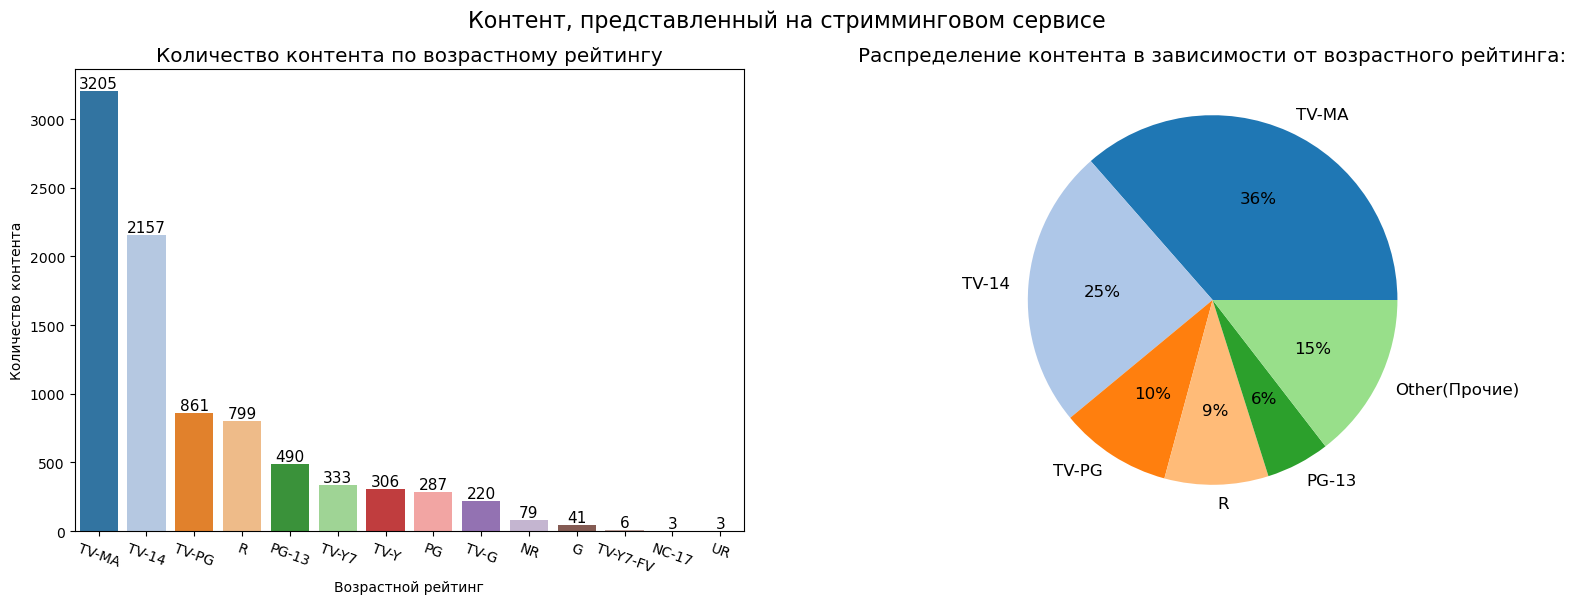

In [17]:
data_rating = (data.groupby(['rating'])
               .title.count()
               .reset_index()
               .sort_values(['title'], ascending = False)
              .reset_index(drop=True))

plt.figure(figsize=(19,6))
plt.suptitle(f'Контент, представленный на стримминговом сервисе', fontsize=16)

plt.subplot(1, 2, 1)
left = sns.barplot(x='rating', y='title', data=data_rating)
plt.bar_label(left.containers[0], size=11, label_type='edge')
plt.rcParams['font.size'] = 12.0
plt.title(f'Количество контента по возрастному рейтингу')
plt.xlabel(f'Возрастной рейтинг')
plt.ylabel(f'Количество контента')
plt.xticks(rotation = 340)

#При построении круговой диаграммы оставим 5 возрастных рейтингов  с наибольшим количеством контента, остальные объединим
others = data_rating.iloc[5:]['title'].sum()
data_rating = data_rating[:5]
data_rating.loc[5] = ['Оther(Прочие)', others]

plt.subplot(1, 2, 2)
plt.pie(data_rating['title'], labels=data_rating['rating'],autopct='%.0f%%')
plt.title(f'Распределение контента в зависимости от возрастного рейтинга:')
plt.show()

Также проанализируем в разрезе типов контента.

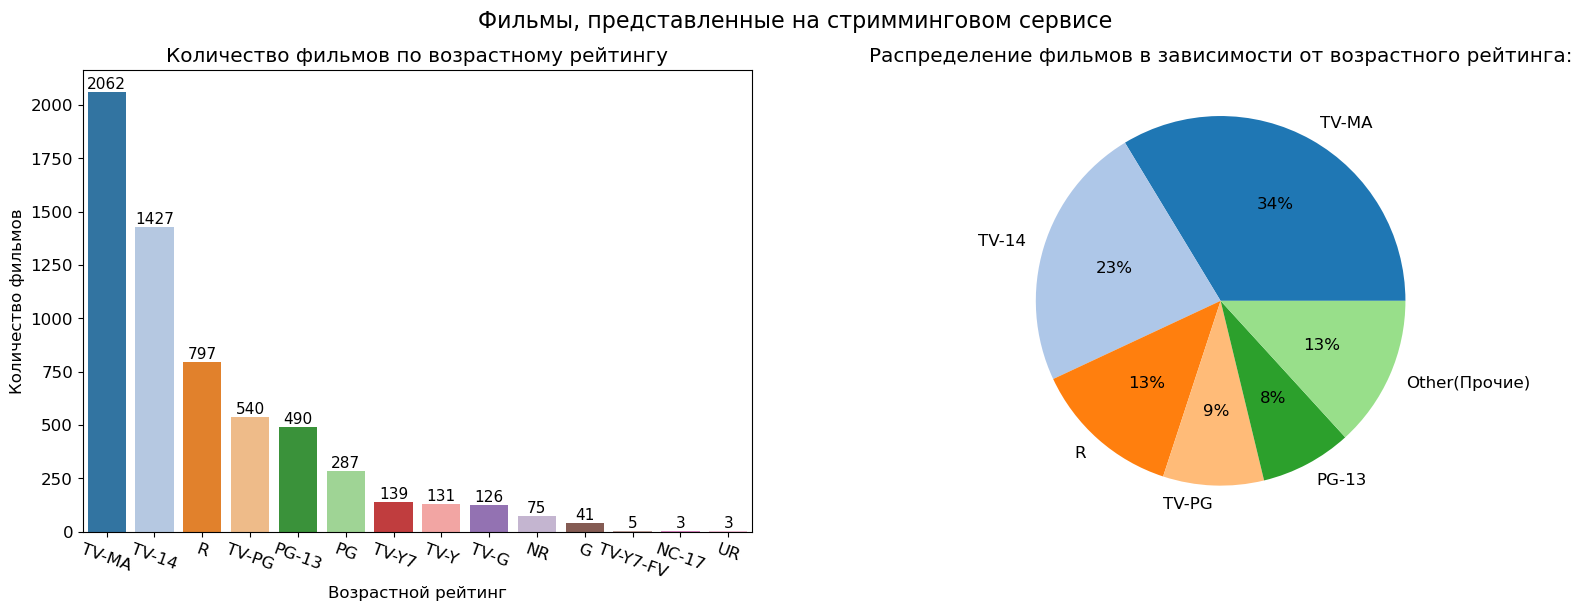

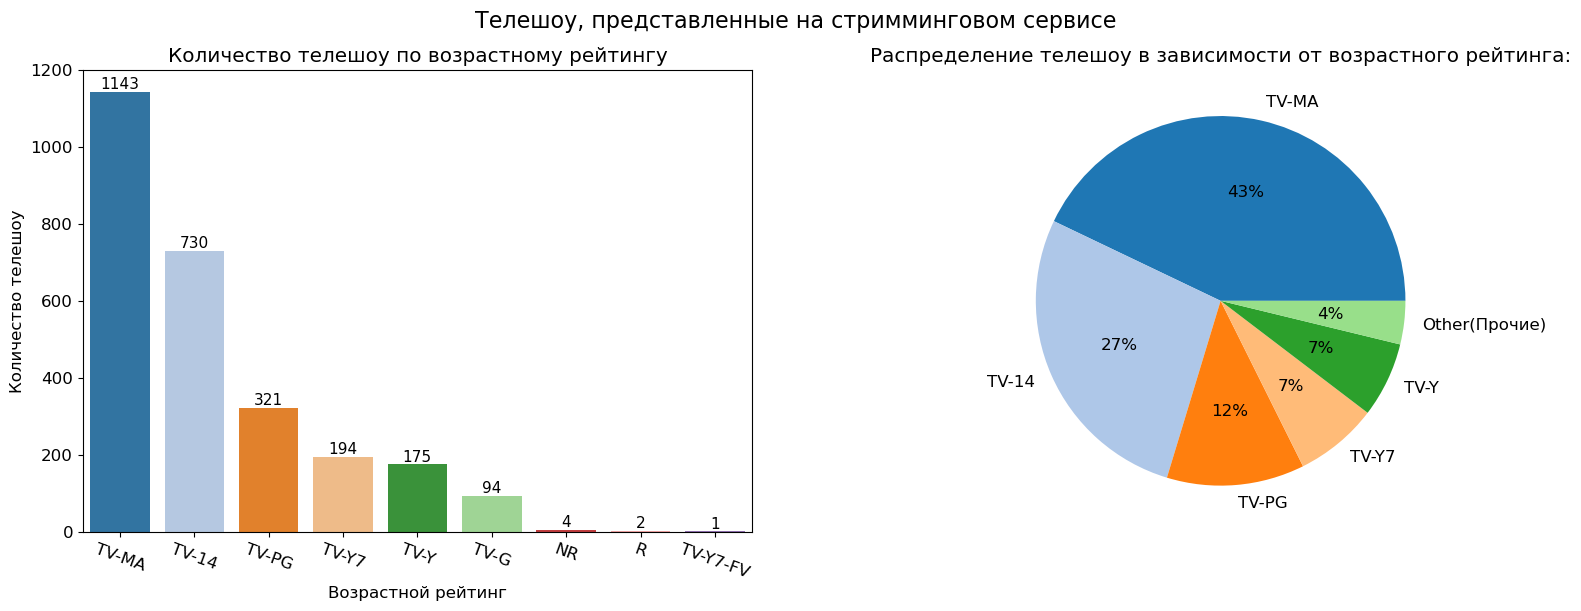

In [18]:
for i in ['Movie', 'TV Show']:
    names_dict = {'Movie': ['фильма', 'фильмов', 'Фильмы'], 
              'TV Show': ['телешоу', 'телешоу', 'Телешоу']}

    data_rating_t = (data.query('type == @i')
                     .groupby('rating')
                     .title.count()
                     .reset_index()
                     .sort_values('title', ascending = False)
                     .reset_index(drop=True))

                
    plt.figure(figsize=(19,6))
    plt.suptitle(f'{names_dict[i][2]}, представленные на стримминговом сервисе', fontsize=16)
        
    plt.subplot(1, 2, 1)
    left = sns.barplot(x='rating', y='title', data=data_rating_t)
    plt.bar_label(left.containers[0], size=11, label_type='edge')
    plt.rcParams['font.size'] = 12.0
    plt.title(f'Количество {names_dict[i][1]} по возрастному рейтингу')
    plt.xlabel(f'Возрастной рейтинг')
    plt.ylabel(f'Количество {names_dict[i][1]}')
    plt.xticks(rotation = 340)

    #При построении круговой диаграммы оставим 5 возрастных рейтингов  с наибольшим количеством контента, остальные объединим
    others = data_rating_t.iloc[5:]['title'].sum()
    data_rating_t = data_rating_t[:5]
    data_rating_t.loc[5] = ['Оther(Прочие)', others]
    
    plt.subplot(1, 2, 2)
    plt.pie(data_rating_t['title'], labels=data_rating_t['rating'],autopct='%.0f%%')
    plt.title(f'Распределение {names_dict[i][1]} в зависимости от возрастного рейтинга:')
    plt.show()

    print()

**Вывод:**
Наибольшее количество фильмов и телешоу, представленных в данных относятся к возрастным рейтингам 'TV-MA', 'TV-14', 'TV-PG' (более 10% от общего количества в каждый).
13% от общего количества фильмов имеют возрастной рейтинг 'R', телешоу с подобный рейтингом представлены мало.

### Изучение продолжительности контента, представленного на стримминговом сервисе

Изучим продолжительность контента, представленного в данных по каждому из типов.

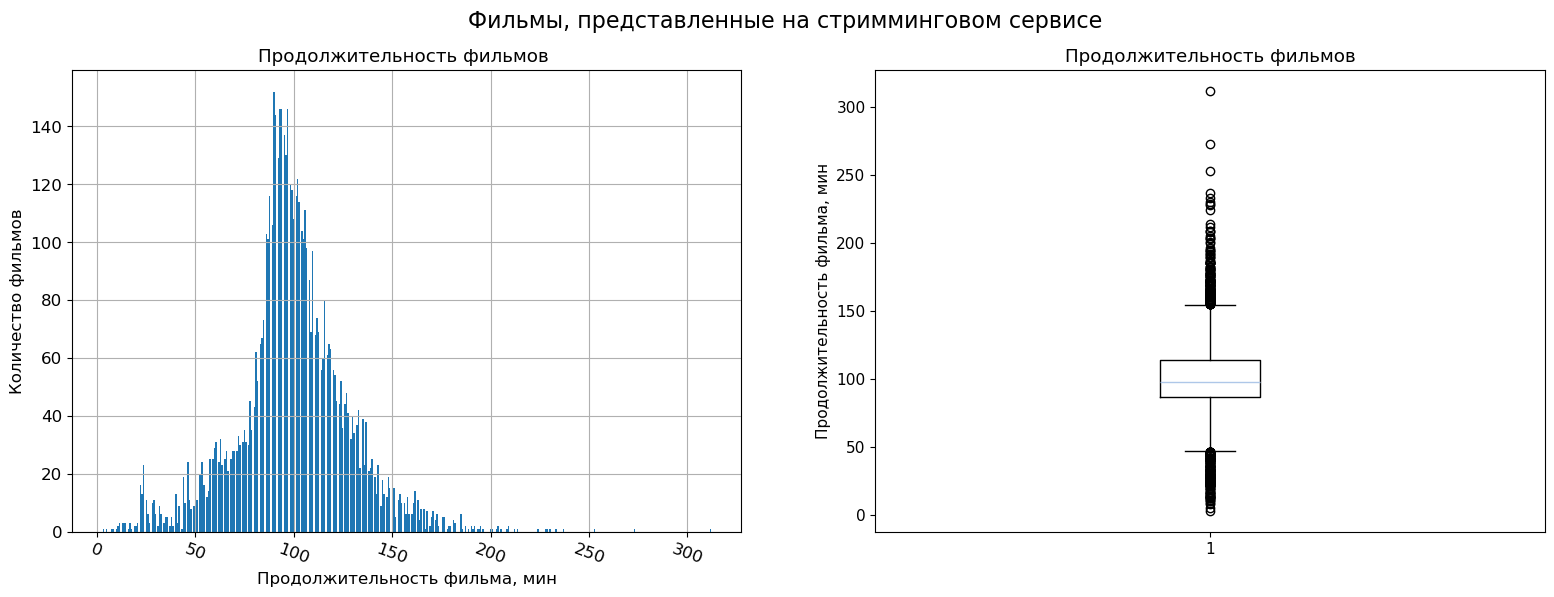


count    6126.000000
mean       99.584884
std        28.283225
min         3.000000
25%        87.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: duration, dtype: float64



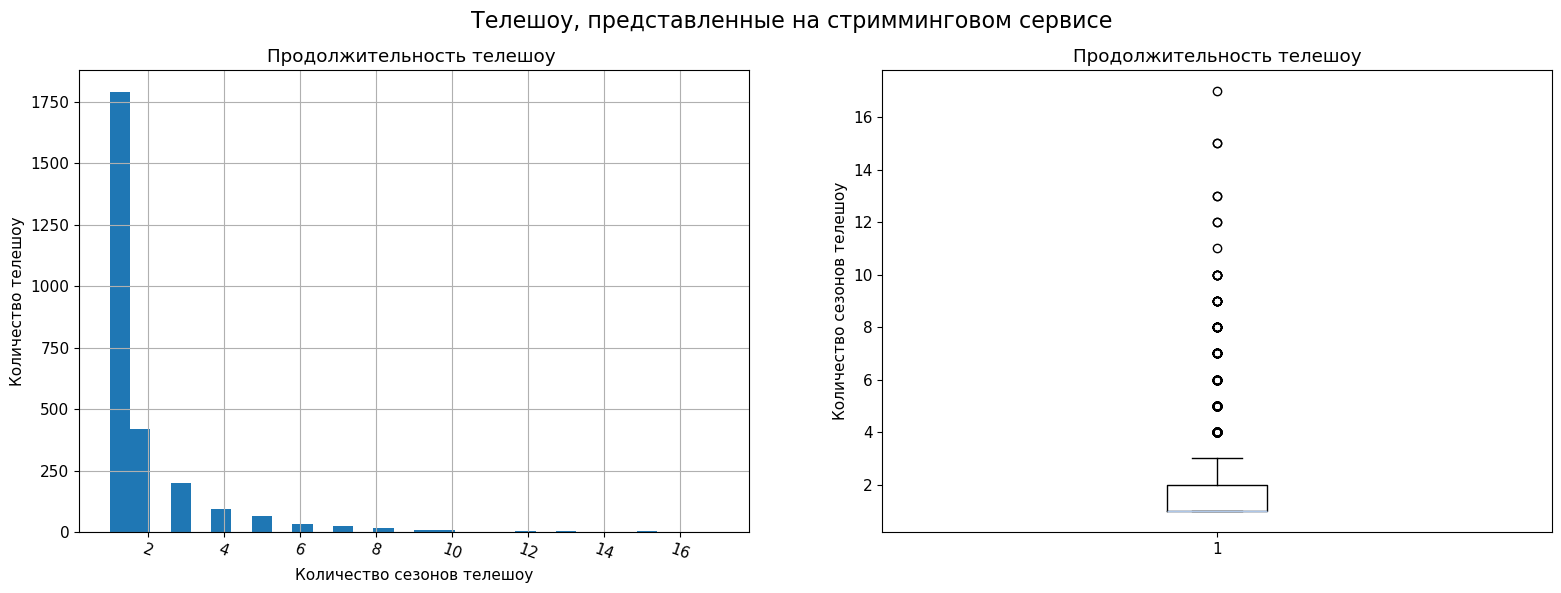


count    2664.000000
mean        1.751877
std         1.550622
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: duration, dtype: float64



In [19]:
for i in ['Movie', 'TV Show']:
    names_dict = {'Movie': ['фильма', 'фильмов', 'Фильмы', 'Продолжительность фильма, мин'], 
              'TV Show': ['телешоу', 'телешоу','Телешоу', 'Количество сезонов телешоу']}
        
    plt.figure(figsize=(19,6))
    plt.suptitle(f'{names_dict[i][2]}, представленные на стримминговом сервисе',  fontsize=16)
    
    plt.subplot(1, 2, 1)
    bins = data.query('type == @i')['duration'].nunique() *2
    data.query('type == @i')['duration'].hist(bins = bins)
    plt.rcParams['font.size'] = 11.0
    plt.title(f'Продолжительность {names_dict[i][1]} ')
    plt.xlabel(names_dict[i][3])
    plt.ylabel(f'Количество {names_dict[i][1]}')
    plt.xticks(rotation = 340)
    
    plt.subplot(1, 2, 2)
    plt.boxplot(data.query('type == @i')['duration'])
    plt.title(f'Продолжительность {names_dict[i][1]}')
    plt.ylabel(names_dict[i][3])
    plt.show()
    print()
    print(data.query('type == @i')['duration'].describe())
    print()

**Вывод:**
1. Средняя  и медианная продолжительность фильмов примерно равны и составляют около 99 минут. Распределение продолжительности фильмов, представленных в данных близко к нормальному. В границах нормального распределения находятся фильмы с продолжительностью от 50 до 150 минут.
2. Продолжительность телешоу имеет ярко выраженное правостороннее распределение. Среднее значение - 1,75 сезонов, медиана - 1 сезон. Большинство телешоу выпускались не более одного сезона. Телешоу продолжительностью более трех сезоном крайне мало.

### Изучение количества контента по годам добавления на стримминговый сервис и годам релиза

##### Изучение количества контента по годам добавления на стримминговый сервис 

Добавим в данные столбец с годом добавления контента в стримминговый сервис. И визуализируем количество контента, добавленного в Netflix  с течением времени.

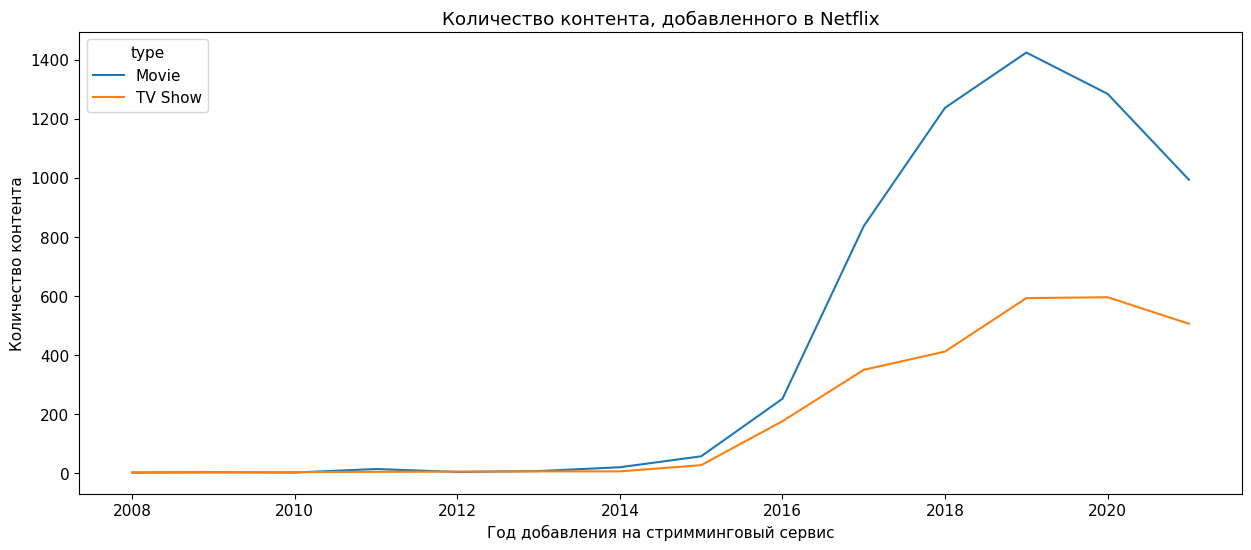

In [20]:
data['year_added'] = data['date_added'].dt.year

title_counts = data.groupby(['type','year_added'])['title'].count().reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(data=title_counts, x='year_added', y="title", hue = 'type', palette = 'tab10')
plt.title(f'Количество контента, добавленного в Netflix')
plt.xlabel('Год добавления на стримминговый сервис')
plt.ylabel('Количество контента')
plt.show()

Дополнительно определим максимальную дату добавления контента в представленных данных. 

In [21]:
data['date_added'].max()

Timestamp('2021-09-25 00:00:00')

**Вывод:** Рост добавления в Netflix фильмов и телешоу фиксируется с 2015 года, что может быть связано с возрастающей популярностью сервисаи постепенным завоеванием доли на рынке. 
Уменьшение количества контента после 2019 года может быть связано как с меньшим количеством релизов в следствии пандемии короновируса, так и неполнотой данных за 2021 год.

##### Изучение количества контента по  годам релиза

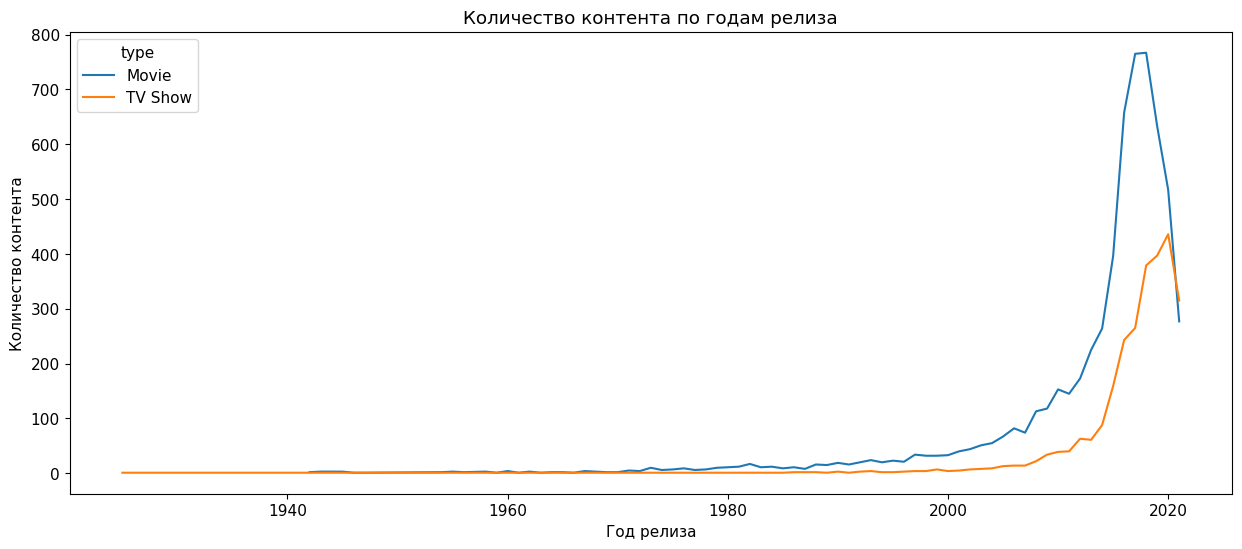

In [22]:
data_release = data.groupby(['type','release_year']).title.count().reset_index()
plt.figure(figsize=(15,6))
sns.lineplot(data = data_release, x = 'release_year', y = 'title', hue = 'type', palette = 'tab10')
plt.title(f'Количество контента по годам релиза')
plt.xlabel('Год релиза')
plt.ylabel('Количество контента')
plt.show()

**Вывод:** Увеличение количества контента с увеличением года релиза связано с 2 факторами:
* развитием рынка киноиндустрии и увеличением количества релизов по годам,
* востребованностью на сервисе более современных фильмов и телешоу.  
Уменьшение количества контента, вышедшего  после 2019 года также  может быть связано как с меньшим количеством релизов в следствии пандемии короновируса, так и неполнотой данных за 2021 год.

### Анализ столбцов с множественными значениями.

Корректно проанализировать столбцы с актерским составом не представляется возможным, так как крайне мала вероятность наличия двух фильмов с одинаковым составом актеров. При этом изменение последовательности актеров в касте также формирует новое значение в столбце.  

Анализ контента по жанрами также возможен только в групперовке по одинаковому составу жанров.  

Аналогичная ситуация может прослеживается и в столбцах с режисером и страной производства фильма(телешоу), так как фильм может быть произведен в сотрудничестве двух и более режиссеров и в двух и более странах.  

При этом есть возможность выявить уникальные значения, входящие в перечисленные выше столбцы, посчитать количество вхождений данных значений и составить  топ.

Для анализа и составления топа по столбцам с множественными значениями, была объявлена соответствующая функция.

In [23]:
def top(data, columns, n, visual = True):
    '''Функция принимает на вход датафрейм, название столбца c множественными значениями, и целое число(n), 
    подсчитывает количество вхождений каждого из уникальных значений в столбце, и, либо возвращает датафрейм с топ-n  вхождений, 
    либо визуализирует полученный результат(по умолчанию).    
    '''
    # Объявляем словарь, содержащий значения для подписей графиков.
    names_dict = {'director': ['Режиссер', 'режиссеров'], 
                  'cast': ['Актер', 'актеров'],
                  'country': ['Страна', 'стран'],
                  'listed_in': ['Жанр', 'жанров'],
                  'Movie': 'фильмов',
                  'TV Show':'телешоу'}
    # Объявляем пустой список, в который в последующем будут добавляться значения из столбца.
    top_list = [] 
    # Формируем глубокую копию фрейма для исключения изменений в исходном.
    copy_data = data.copy(deep=True) 
    # заполняем пропуски в столбце заглушкой.
    copy_data[columns].fillna('unknown',inplace = True)
    #преобразуем значения в стобце в список уникальных значений в нижнем регистре 
    copy_data[columns] = copy_data[columns].map(lambda x: list(set([i.strip().lower() for i in x.split(',')])))
    #добавляем в top_list значения из ячеек, не содержащих заглушку(начальная буква каждого слова переведена в верхний регистр)
    for i in copy_data[columns]:
        if 'unknown' not in i:
            top_list.extend([j.title() for j in i])
    # При помощи типа данных Counter формируем словарь с количеством вхождений каждого значения в top_list.
    # Методом most_common() определяем N-е количество значений с наибольшим числом вхождений и формируем датафрейм.
    top = pd.DataFrame(Counter(top_list).most_common(n), columns=[columns, 'amount'])
    #Визуализируем полученный результат или возвращаем фрейм.
    if visual:
        if len(copy_data["type"].unique()) > 1:
            name = 'контента'
        else:
            name = names_dict[copy_data["type"].unique()[0]]
        plt.figure(figsize=(12,6))
        ax = sns.barplot(data=top, x=columns, y='amount')
        plt.bar_label(ax.containers[0], size=11, label_type='edge')
        plt.title(f'Топ-{n} {names_dict[columns][1]} по количеству {name}, представленных в Netflix')
        plt.xlabel(names_dict[columns][0])
        plt.ylabel(f'Количество {name}')
        plt.xticks(rotation = 340)
        plt.show()
    else:
        return top     

Протестируем функцию с возвращаемым значением, и сформируем датафрейм, содержащий топ-15 странн, по количеству произведенного контента.

In [24]:
top_country = top(data, 'country' , 15, visual = False)
top_country

,country,amount
0,United States,3681
1,India,1046
2,United Kingdom,805
3,Canada,445
4,France,393
5,Japan,316
6,Spain,232
7,South Korea,231
8,Germany,226
9,Mexico,169


Наибольшее количество контента, представленного в стримминговом сервисе, произведено в США, Индии и Великобритании.

Визуализируем топ-7  жанров по количеству телешоу, представленным в данных.

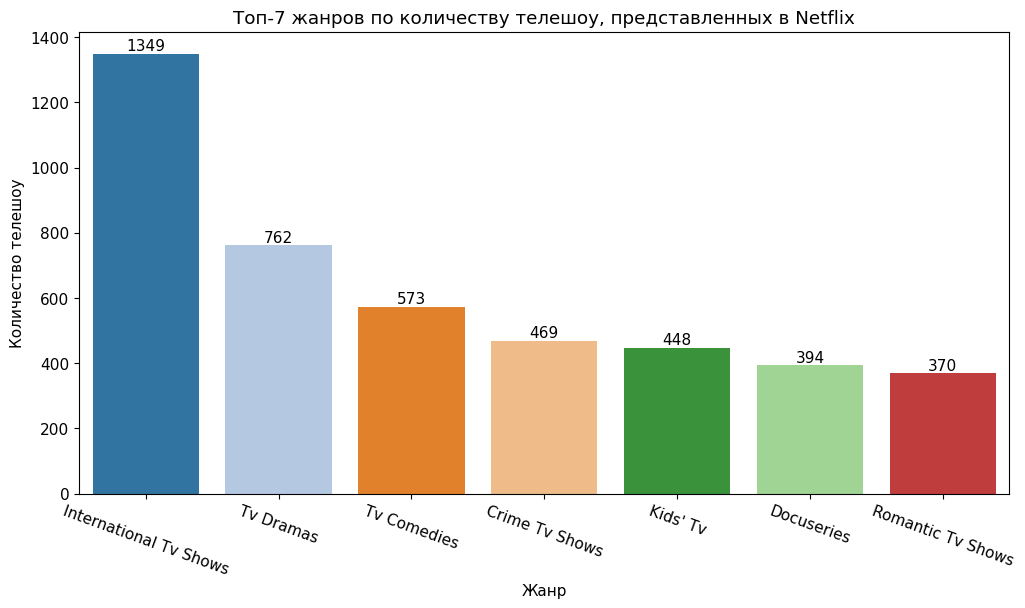

In [25]:
top(data[data['type']=='TV Show'], 'listed_in' , 7)

Наибольшее количество телешоу, размещенных в стимминговом сервисе, представлены в жанрах:
* International TV Shows - 1349 шоу, 
* TV Dramas - 762 шоу,
* TV Comedies - 573 шоу,
* Crime TV Shows - 469 шоу,
* Kids' TV - 448 шоу,
* Docuseries - 394 шоу,
* Romantic TV Shows - 370 шоу.


Также визуализируем топ-5 актеров по количеству фильмов, в которых они сыграли.

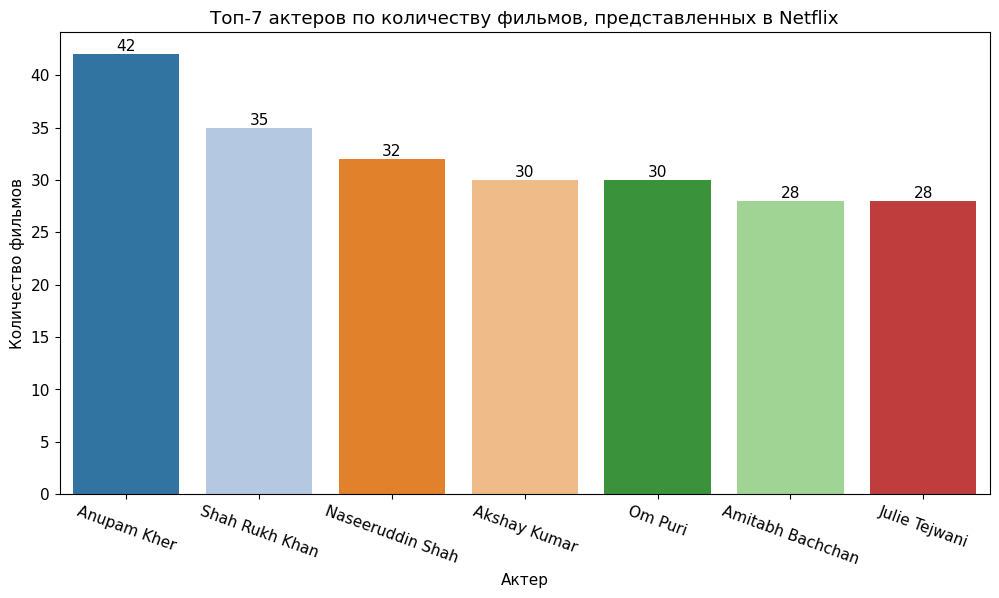

In [26]:
top(data[data['type']!='TV Show'],'cast', 7)

В топ-7 актеров по количеству фильмов входят:
* Anupam Kher - 42 фильма, 
* Shah Rukh Khan - 35 фильмов, 
* Naseeruddin Shah - 32 фильма, ,
* Akshay Kumar - 30 фильмов,
* Om Puri- 30 фильмов, 
* Amitabh Bachchan - 28 фильмов,  
* Julie Tejwani - 28 фильмов. 

**Вывод:** Объявленная функция дает возможность проанализировать количество уникальных значений в столбцах с множественными значениями.

## Статистический анализ

На основании представленных данных, можно провести статистический анализ длительности фильмов по возрастному рейтингу.

Для более корректного результата, сформируем перечень рейтингов, представленных в фрейме более чем пятиста фильмами.

In [27]:
date2 = data[data['type']!='TV Show'].groupby('rating').title.count().reset_index()
date2 = date2.query('title>500')
date2

,rating,title
5,R,797
6,TV-14,1427
8,TV-MA,2062
9,TV-PG,540


Определяем количество попарных сравнений для поправки на множественные сравнения методом Холма.

In [28]:
holm = int(factorial(date2.shape[0])/(factorial(2)*factorial(date2.shape[0] - 2)))
holm

6

Проверим гипотезы на равенство средних значений длительности фильмов различных возрастных рейтингов. 

In [29]:
data_movie = data.query('type == "Movie"')

### Проверка гипотезы  t-критерием Стьюдента

In [30]:
a, num = [], 1
for i in date2['rating'].unique():
    for j in date2['rating'].unique():
        if i!= j and sorted((i,j)) not in a:
            a.append(sorted((i,j)))
            print(f'{num})  Гипотезы:')
            print( f'H_0: Средняя длительность фильмов рейтингa "{i}" = Средняя длительность фильмов рейтингa "{j}"')
            print( f'H_0: Средняя длительность фильмов рейтингa "{i}" ≠ Средняя длительность фильмов рейтингa "{j}"')
       
            results = st.ttest_ind(data_movie[data_movie['rating'] == i]['duration']
                                   , data_movie[data_movie['rating'] == j]['duration']
                                     , equal_var = False)
        
            
            alpha  = 0.05/(holm - num + 1) # задаем уровень стат значимости споправкой к множественному сравнению методом Холма
            
            print('p-value:', results.pvalue)
            
            if results.pvalue < alpha:
                print('Отвергаем нулевую гипотезу')
            else:
                print('Не получилось отвергнуть нулевую гипотезу')
            num+=1
            print()

1)  Гипотезы:
H_0: Средняя длительность фильмов рейтингa "R" = Средняя длительность фильмов рейтингa "TV-14"
H_0: Средняя длительность фильмов рейтингa "R" ≠ Средняя длительность фильмов рейтингa "TV-14"
p-value: 0.0006077073431451299
Отвергаем нулевую гипотезу

2)  Гипотезы:
H_0: Средняя длительность фильмов рейтингa "R" = Средняя длительность фильмов рейтингa "TV-MA"
H_0: Средняя длительность фильмов рейтингa "R" ≠ Средняя длительность фильмов рейтингa "TV-MA"
p-value: 1.2414174992333105e-36
Отвергаем нулевую гипотезу

3)  Гипотезы:
H_0: Средняя длительность фильмов рейтингa "R" = Средняя длительность фильмов рейтингa "TV-PG"
H_0: Средняя длительность фильмов рейтингa "R" ≠ Средняя длительность фильмов рейтингa "TV-PG"
p-value: 3.8427168231584307e-13
Отвергаем нулевую гипотезу

4)  Гипотезы:
H_0: Средняя длительность фильмов рейтингa "TV-14" = Средняя длительность фильмов рейтингa "TV-MA"
H_0: Средняя длительность фильмов рейтингa "TV-14" ≠ Средняя длительность фильмов рейтингa "TV-M

### Проверка гипотезы  U-критерием Манна-Уитни

In [31]:
a, num = [], 1
for i in date2['rating'].unique():
    for j in date2['rating'].unique():
        if i!= j and sorted((i,j)) not in a:
            a.append(sorted((i,j)))
            print(f'{num})  Гипотезы:')
            print( f'H_0: Средняя длительность фильмов рейтингa "{i}" = Средняя длительность фильмов рейтингa "{j}"')
            print( f'H_0: Средняя длительность фильмов рейтингa "{i}" ≠ Средняя длительность фильмов рейтингa "{j}"')
       
            results = st.mannwhitneyu(data_movie[data_movie['rating'] == i]['duration']
                                   , data_movie[data_movie['rating'] == j]['duration'])
        
            
            alpha  = 0.05/(holm - num + 1) # задаем уровень стат значимости споправкой к множественному сравнению методом Холма
            
            print('p-value:', results.pvalue)
            
            if results.pvalue < alpha:
                print('Отвергаем нулевую гипотезу')
            else:
                print('Не получилось отвергнуть нулевую гипотезу')
            num+=1
            print()

1)  Гипотезы:
H_0: Средняя длительность фильмов рейтингa "R" = Средняя длительность фильмов рейтингa "TV-14"
H_0: Средняя длительность фильмов рейтингa "R" ≠ Средняя длительность фильмов рейтингa "TV-14"
p-value: 0.0007438913674439145
Отвергаем нулевую гипотезу

2)  Гипотезы:
H_0: Средняя длительность фильмов рейтингa "R" = Средняя длительность фильмов рейтингa "TV-MA"
H_0: Средняя длительность фильмов рейтингa "R" ≠ Средняя длительность фильмов рейтингa "TV-MA"
p-value: 4.4306128953923106e-32
Отвергаем нулевую гипотезу

3)  Гипотезы:
H_0: Средняя длительность фильмов рейтингa "R" = Средняя длительность фильмов рейтингa "TV-PG"
H_0: Средняя длительность фильмов рейтингa "R" ≠ Средняя длительность фильмов рейтингa "TV-PG"
p-value: 7.394534680041833e-15
Отвергаем нулевую гипотезу

4)  Гипотезы:
H_0: Средняя длительность фильмов рейтингa "TV-14" = Средняя длительность фильмов рейтингa "TV-MA"
H_0: Средняя длительность фильмов рейтингa "TV-14" ≠ Средняя длительность фильмов рейтингa "TV-MA

### **Вывод:** 
Проверка гипотез двумя критериями показала идентичные результаты.
Средняя длительность фильмов, относящихся к разным возрастным рейтингам статистически отличается.  
Статистическое различие в средней длительности фильмов не наблюдается только среди фильмов рейтингов "TV-MA" и "TV-PG".

# Общий вывод:
В данных представлена информация о 8807 фильмах(сериалах), размещенных на стримминговом сервисе.
На этапе предобработки:
1. Откорректирован тип данных в столбце с датой добавления фильма или телешоу в Netflix,
2. Проработаны пропуски,
3. Значения в столбце с продолжительностью фильма(телешоу) приведены в целочисленный численный формат.

Исследовательский анализ данных показал следующие результаты: 
1. Наибольшее количество фильмов и телешоу, представленных в данных относятся к возрастным рейтингам 'TV-MA', 'TV-14', 'TV-PG' (более 10% от общего количества в каждый). 13% от общего количества фильмов имеют возрастной рейтинг 'R', телешоу с подобный рейтингом представлены мало.
2.	Средняя  и медианная продолжительность фильмов примерно равны и составляют около 99 минут. Распределение продолжительности фильмов, представленных в данных близко к нормальному. В границах нормального распределения находятся фильмы с продолжительностью от 50 до 150 минут.
3.	Продолжительность телешоу имеет ярко выраженное правостороннее распределение. Среднее значение - 1,75 сезонов, медиана - 1 сезон. Большинство телешоу выпускались не более одного сезона. Телешоу продолжительностью более трех сезоном крайне мало.
4.	Контент добавляется на стримминговый сервис с 2008 года.  При этом отчетливый рост фиксируется с 2015 года, что может быть связано с возрастающей популярностью сервиса и постепенным завоеванием доли на рынке.  Уменьшение количества контента после 2019 года может быть связано как с меньшим количеством релизов в следствии пандемии короновируса, так и неполнотой данных за 2021 год.
5.	Отмечено увеличение количества контента на сервисе с увеличением года релиза. Это может быть связано с 2 факторами:
  * развитием рынка киноиндустрии и увеличением количества релизов по годам,
  * востребованностью на сервисе более современных фильмов и телешоу.    
Уменьшение количества контента, вышедшего после 2019 года также  может быть связано как с меньшим количеством релизов в следствии пандемии короновируса, так и неполнотой данных за 2021 год.
6.	Объявлена функция анализа количества уникальных значений в столбцах с множественными значениями.  Определены топы топ-7 актеров и телешоу.
7.	Выявлены статистическое различия в средней длительности фильмов,  относящихся к разным возрастным рейтингам.